Extracting returns signals from Beyond Meat's LOB for OB data for April 2018
===

In [2]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2020
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

Initialising some utility functions, extracting data from LOBster data, calculation of cumulative returns over the month
===

In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of
    
from scipy import stats
def taglia_e_cuci(v):
    hi=np.quantile(v,0.0005)
    lo=np.quantile(v, 0.9995)
    b=np.clip(v, hi,lo)
    return b

In [3]:
msg_files = glob("BYND/*message*.csv")
lob_files = glob("BYND/*order*.csv")
d0 = datetime(2018,4,2)

In [4]:
dfs = []
for day, file in enumerate(np.sort(msg_files)[:]):
    te = pd.read_csv(file, header=None, low_memory=False)
    te['Day'] = d0 + BDay(day)
    dfs.append(te)
df_msg = pd.concat(dfs)

print("{0:0.2f} million observations".format(len(df_msg)/10**6))
df_msg.columns = ['Time', 'Event', 'ID', 'Size', 'Price', 'Direction', '?', 'Day']
df_msg = df_msg.drop(['?'], axis=1)
df_msg['Execution'] = np.where(df_msg['Event'].isin([4,5]), 1, 0)
# 4: Execution of a visible limit order
# 5: Execution of a hidden limit order

13.98 million observations


In [5]:
df_msg_exe=df_msg[df_msg['Execution']==1]
print("{0:0.2f} million observations".format(len(df_msg_exe)/10**6))

3.02 million observations


In [6]:

dfs = []
for file in np.sort(lob_files)[:]:
    te = pd.read_csv(file, header=None)
    dfs.append(te)
df_lob  = pd.concat(dfs)
cols = np.ravel([['AP%d'%level, 'AS%d'%level, 'BP%d'%level, 'BS%d'%level] for level in [1,2,3]])
df_lob.columns = cols
print("{0:0.2f} million observations".format(len(df_lob)/10**6))

13.98 million observations


In [7]:
df_lob.reset_index(inplace=True)
df_msg.reset_index(inplace=True)
df = pd.concat([df_msg, df_lob], axis=1)
df = df[df['Execution']==1]
df.dropna(inplace=True)
lob_data=df[cols]
lob_data.head()

,AP1,AS1,BP1,BS1,AP2,AS2,BP2,BS2,AP3,AS3,BP3,BS3
16,762500,51,762000,350,763000,51,761500,297,763500,1,761000,1046
17,762500,1,762000,350,763000,51,761500,297,763500,1,761000,1046
18,763000,51,762000,350,763500,1,761500,297,763600,1,761000,1046
22,762400,10,762000,350,763000,51,761500,297,763500,1,761000,1046
23,762400,10,762000,150,763000,51,761500,297,763500,1,761000,1046


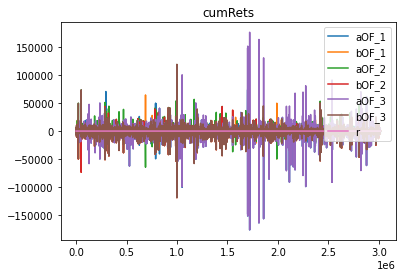

In [8]:
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
m=pd.DataFrame(midPrice(lob_data),columns=['m'])
m['r']=m['m'].pct_change()#diff()#calcola le differenze di midprice ogni 10 eventi ->differenze secondo il vettore h_K
m['rCum']=m['r'].cumsum()
of_data['r']=m['rCum']#*100
of_data.dropna(inplace=True)
of_data.plot()
plt.title('cumRets')
plt.show()

Prepares the dataset: cuts at 0.5% the tails, and splits data in the requested formats
===

In [9]:
offlo=of_data.apply(lambda x: taglia_e_cuci(x))

In [10]:
def prepare_x(data):
    df1 = data[:, :6]
    return np.array(df1)

def get_label(data):
    lob = data[:, -1:]
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(-1,100,6,1), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    #y = y[:,k]
    #y = np_utils.to_categorical(y, 3)
    return x, y

In [11]:
vali_weight=0.05

In [12]:
#fa dataset
y=offlo['r'].to_numpy()
idx=10000
horiz=1
T=100
r=np.empty((idx,horiz))
med=np.empty((idx,horiz))
h=[ 22]#, 44, 89, 133, 178, 223, 267, 312, 356, 401]

for i in range(idx): #righe
    for ii,iii in zip(range(horiz),h): #colonne, steps
        r[i,ii]=y[i+iii]-y[i]
        med[i][ii]=np.mean(y[:i+iii])

X=offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:1000000]

x=X.to_numpy()
dataX=x.reshape(-1,100,6,1)
erre=r
r.shape, dataX.shape, med.shape

((10000, 1), (10000, 100, 6, 1), (10000, 1))

In [13]:
#fa supervised dataset: train, val e test
l=len(dataX)
a=int(9000)
b=int( 999)
x_vecc_train=dataX[:a]

mu=x_vecc_train.mean()
sd=x_vecc_train.std()
stdize=lambda x: x/sd


x_vecc_train=dataX[:a]/sd
r_train     =r[:a]
x_vecc_val  =dataX[a:a+b]/sd
r_val       =r[a:a+b]
x_vecc_test =dataX[a+b:a+b+1]/sd
r_test      =r[a+b:a+b+1]


print(x_vecc_train.shape, r_train.shape)
print(x_vecc_val.shape,   r_val.shape)
print(x_vecc_test.shape,  r_test.shape)


(9000, 100, 6, 1) (9000, 1)
(999, 100, 6, 1) (999, 1)
(1, 100, 6, 1) (1, 1)


CNN/LSTM
===

In [14]:
#architettura della rete
def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    #  LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)
    # output layer
    out = Dense(horiz, activation='leaky_relu')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mse')#, metrics=['accuracy']

    return model
  
deeplob = create_nn(100, 6, 64)

deeplob.summary()
checkpoint_filepath = './model_tensorflow2/weights'


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [15]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [16]:
simple=deeplob.fit(x_vecc_train, r_train, validation_data=(x_vecc_val, r_val),  epochs=50, batch_size=250,callbacks=[callback,saving])

Epoch 1/50
36/36 [==============================] - 9s 221ms/step - loss: 2.0840e-04 - val_loss: 1.4588e-04
Epoch 2/50
36/36 [==============================] - 8s 209ms/step - loss: 4.6812e-05 - val_loss: 6.2891e-05
Epoch 3/50
36/36 [==============================] - 8s 211ms/step - loss: 3.9378e-05 - val_loss: 4.2228e-05
Epoch 4/50
36/36 [==============================] - 8s 216ms/step - loss: 2.4101e-05 - val_loss: 2.7934e-05
Epoch 5/50
36/36 [==============================] - 8s 215ms/step - loss: 1.7464e-05 - val_loss: 2.9028e-05
Epoch 6/50
36/36 [==============================] - 8s 214ms/step - loss: 1.2991e-05 - val_loss: 1.9790e-05
Epoch 7/50
36/36 [==============================] - 8s 213ms/step - loss: 1.0891e-05 - val_loss: 1.5985e-05
Epoch 8/50
36/36 [==============================] - 8s 213ms/step - loss: 8.9671e-06 - val_loss: 1.2938e-05
Epoch 9/50
36/36 [==============================] - 8s 212ms/step - loss: 8.4134e-06 - val_loss: 1.4207e-05
Epoch 10/50
36/36 [=========

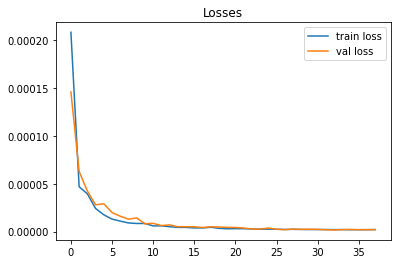

In [17]:
plt.plot(simple.history['loss'], label='train loss')
plt.plot(simple.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses');

In [18]:
Ptest = deeplob.predict(x_vecc_test)

1/1 [==============================] - 0s 328ms/step


In [19]:
true=r_test
fcst=Ptest
u=np.array([np.mean(r[-22:])]).flatten()
num=((true-fcst))**2
den=((true-np.mean(med[-1:])))**2
r2OutS_modello=((den-num)/den)

In [20]:
r2OutS_modello

array([[0.8765146]])

LSTM
===

In [21]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.0001)
loss_function = 'mse'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.7)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(horiz, activation='leaky_relu')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function)

lstmMSFT=model.fit(x_vecc_train, r_train, batch_size = batch_size, epochs = num_epochs,validation_data=(x_vecc_val, r_val),callbacks=[callback])

Epoch 1/50
36/36 [==============================] - 16s 373ms/step - loss: 1.8961e-04 - val_loss: 4.8765e-05
Epoch 2/50
36/36 [==============================] - 15s 408ms/step - loss: 2.5935e-05 - val_loss: 2.2090e-05
Epoch 3/50
36/36 [==============================] - 15s 424ms/step - loss: 1.6884e-05 - val_loss: 1.5215e-05
Epoch 4/50
36/36 [==============================] - 15s 421ms/step - loss: 1.4064e-05 - val_loss: 1.6515e-05
Epoch 5/50
36/36 [==============================] - 15s 424ms/step - loss: 1.2384e-05 - val_loss: 1.3898e-05
Epoch 6/50
36/36 [==============================] - 15s 419ms/step - loss: 1.1220e-05 - val_loss: 1.3942e-05
Epoch 7/50
36/36 [==============================] - 15s 424ms/step - loss: 1.0392e-05 - val_loss: 1.3605e-05
Epoch 8/50
36/36 [==============================] - 15s 420ms/step - loss: 9.5179e-06 - val_loss: 1.1487e-05
Epoch 9/50
36/36 [==============================] - 15s 426ms/step - loss: 9.2527e-06 - val_loss: 1.0995e-05
Epoch 10/50
36/36 [

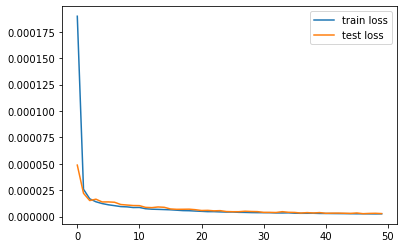

In [22]:
plt.plot(lstmMSFT.history['loss'], label='train loss')
plt.plot(lstmMSFT.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [23]:
PtestLSTM = model.predict(x_vecc_test)

1/1 [==============================] - 1s 679ms/step


In [24]:
trueLSTM=r_test
fcstLSTM=PtestLSTM
u=np.array([np.mean(r[-22:])]).flatten()
num=(true-fcstLSTM)**2
den=(true-np.mean(med[-1:]))**2#trueLSTM-umed[0]erre[0][-22:].flatten()
r2OutSLSTM=((den-num)/den)
r2OutSLSTM

array([[-1.35527354]])

ARX-REGRESSION
===

In [28]:
offRed=offlo[:100000]
y=                                                  offRed['r'][:-22].to_numpy()
x=    offRed[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:-22].to_numpy()
xFcst=offRed[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][-22:].to_numpy()
yFcst=                                              offRed['r'][-23:].to_numpy()

mdl = NARX(LinearRegression(), auto_order=1, exog_order=[100,100,100,100,100,100])
mdl.fit(x,y)

y_forecast = mdl.forecast(x, y, step=23, X_future=xFcst)
y_forecast,yFcst

(array([0.11690346, 0.11691384, 0.11685727, 0.11679067, 0.11674423,
        0.11671286, 0.11673324, 0.11674024, 0.11673334, 0.11674108,
        0.11674549, 0.11675651, 0.11673854, 0.11672763, 0.11682813,
        0.11670423, 0.11665927, 0.11665537, 0.11670553, 0.11664753,
        0.11664862, 0.11669985, 0.1167393 ]),
 array([0.11693092, 0.11693092, 0.11693092, 0.1168139 , 0.11657983,
        0.1165213 , 0.1163457 , 0.1163457 , 0.11681406, 0.11681406,
        0.11681406, 0.11681406, 0.11681406, 0.11611185, 0.11611185,
        0.11687311, 0.11611243, 0.11611243, 0.11611243, 0.11640522,
        0.11611251, 0.1159954 , 0.11605396]))

In [29]:
fore22=y_forecast[0]-y_forecast[-1]
vero22=yFcst[0]-yFcst[-1]
veroBar=np.mean(yFcst)
num=(vero22-fore22)**2
den=(vero22-veroBar)**2
r2OutSARX=((den-num)/den)
r2OutSARX

0.9999619929861135

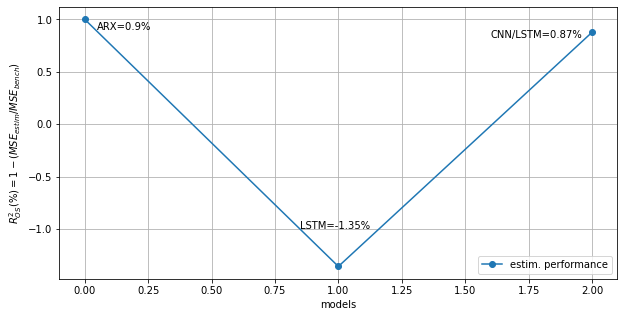

In [31]:
dict={'ARX':0.9999619929861135,'LSTM':-1.35527354,'CNN/LSTM':0.8765146}
r2OutSARX=0.9999619929861135
r2OutSLSTM=-1.35527354
r2OutS_modello=0.8765146
topl=pd.DataFrame([dict])
dd=np.zeros(3)
toplot=[r2OutSARX,
        r2OutSLSTM,
        r2OutS_modello]
for i in range(1,3):
    dd[i]=1/(toplot[i-1]-toplot[i])
plt.figure(figsize=(10,5))
plt.plot(toplot,'o-',label='estim. performance')
plt.annotate('ARX=0.9%'     , (0.05,0.9))
plt.annotate('LSTM=-1.35%'    ,(0.85,-1.))
plt.annotate('CNN/LSTM=0.87%',(1.6,0.82))
plt.ylabel('$R^2_{OS}(\%)=1- (MSE_{estim} / MSE_{bench})$')
plt.xlabel('models')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("MSFT_res.pdf")
plt.show()